## Import packages

In [1]:

import numpy as np
import torch
import shutil
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary
from tensorboardX import SummaryWriter

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 9)

In [2]:
from config import opt
from models import FlowersFcModel
from utils import train_one_epoch, validate_one_epoch, get_val_metrics, get_images_paths, get_train_test_split, show_tensor_images, save_checkpoint, init_seeds
from datasets import FlowersDataset
from datasets.preprocessing import train_transformations_without_norm, val_transformations_without_norm

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [3]:
init_seeds(opt.seed)

## Prepare dataset

In [4]:
num_classes = len(set(opt.idx_to_class.keys()))

In [5]:
data_df = get_images_paths(opt=opt)
train_df, val_df = get_train_test_split(df=data_df, opt=opt)

In [6]:
data_df.label.value_counts()

4    602
0    518
2    472
3    420
1    239
Name: label, dtype: int64

In [7]:
train_dataset = FlowersDataset(
    img_paths=train_df['path'].values.copy(),
    labels=train_df['label'].values.copy(),
    num_classes=num_classes,
    transform=train_transformations_without_norm,
    use_descriptors_as_features=opt.use_descriptors_as_features,
    features_type=opt.features_type,
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers=opt.num_workers,
    pin_memory=opt.pin_memory,
)

val_dataset = FlowersDataset(
    img_paths=val_df['path'].values.copy(),
    labels=val_df['label'].values.copy(),
    num_classes=num_classes,
    transform=val_transformations_without_norm,
    use_descriptors_as_features=opt.use_descriptors_as_features,
    features_type=opt.features_type,
)

val_dataloader = DataLoader(
    train_dataset,
    batch_size=opt.batch_size,
    shuffle=False,
    num_workers=opt.num_workers,
    pin_memory=opt.pin_memory,
)

In [8]:
if opt.features_type == 'gabor':
    t = (next(iter(train_dataloader))['image'].view(opt.batch_size, opt.img_height, opt.img_width, 3).permute(0, 3, 1, 2) + 1 ) / 2.0
    show_tensor_images(t)

In [9]:
if opt.features_type == 'gabor':
    t = (next(iter(val_dataloader))['image'].view(opt.batch_size, opt.img_height, opt.img_width, 3).permute(0, 3, 1, 2) + 1 ) / 2.0
    show_tensor_images(t)

## Training

In [10]:
next(iter(val_dataloader))['image'].shape

torch.Size([32, 12800])

In [11]:
in_features = 12800
hidden_dim = in_features // 2
model = FlowersFcModel(
    in_features=in_features, hidden_dim=hidden_dim, num_classes=num_classes
).to(opt.device)
# model.freeze_middle_layers()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=opt.lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1, verbose=True)

In [12]:
summary(model, input_size=(in_features, ), batch_size=opt.batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [32, 6400]      81,926,400
         LeakyReLU-2                 [32, 6400]               0
       BatchNorm1d-3                 [32, 6400]          12,800
           Dropout-4                 [32, 6400]               0
            Linear-5                  [32, 800]       5,120,800
         LeakyReLU-6                  [32, 800]               0
       BatchNorm1d-7                  [32, 800]           1,600
           Dropout-8                  [32, 800]               0
            Linear-9                  [32, 400]         320,400
        LeakyReLU-10                  [32, 400]               0
      BatchNorm1d-11                  [32, 400]             800
          Dropout-12                  [32, 400]               0
           Linear-13                  [32, 200]          80,200
        LeakyReLU-14                  [

In [13]:
best_target_metric = -np.inf
target_metric = 'f1_avg'
model_writer_path = opt.path_to_tensorboard_logs / model.__class__.__name__

if model_writer_path.exists():
    shutil.rmtree(model_writer_path)
writer = SummaryWriter(log_dir=str(model_writer_path))

for epoch in range(opt.start_epoch, opt.epochs):
    # train for one epoch
    train_metrics = train_one_epoch(train_dataloader, model, criterion, optimizer, epoch, opt.device, opt.print_freq, writer)

    # evaluate on validation set
    val_metrics = validate_one_epoch(val_dataloader, model, criterion, epoch, opt.device, opt.print_freq, writer)
    
    # learning rate scheduler step
    scheduler.step(val_metrics['loss_avg'])

    # remember best value and save checkpoint
    target_metric_value = val_metrics[target_metric]
    is_best = target_metric_value > best_target_metric
    best_target_metric = max(target_metric_value, best_target_metric)

    save_checkpoint(
        {
            'epoch': epoch,
            'state_dict': model.state_dict(),
            f'best_{target_metric}': best_target_metric,
            'optimizer' : optimizer.state_dict(),
        },
        is_best,
        filename=str(opt.path_to_models / f'{model.__class__.__name__}_checkpoint.pth'),
        best_filename=str(opt.path_to_models / f'{model.__class__.__name__}_model_best.pth'),
    )
writer.close()

Epoch: [0][ 0/57]	Time  1.819 ( 1.819)	Data  1.391 ( 1.391)	Loss 1.9076e+00 (1.9076e+00)	Acc   0.16 (  0.16)	F1   0.17 (  0.17)
Epoch: [0][10/57]	Time  0.265 ( 0.427)	Data  0.008 ( 0.136)	Loss 1.2047e+00 (1.7633e+00)	Acc   0.56 (  0.32)	F1   0.50 (  0.30)
Epoch: [0][20/57]	Time  0.259 ( 0.352)	Data  0.008 ( 0.075)	Loss 1.7416e+00 (1.6762e+00)	Acc   0.22 (  0.32)	F1   0.20 (  0.30)
Epoch: [0][30/57]	Time  0.266 ( 0.328)	Data  0.008 ( 0.053)	Loss 1.4293e+00 (1.6395e+00)	Acc   0.25 (  0.30)	F1   0.24 (  0.29)
Epoch: [0][40/57]	Time  0.301 ( 0.316)	Data  0.008 ( 0.042)	Loss 1.5368e+00 (1.6067e+00)	Acc   0.31 (  0.31)	F1   0.27 (  0.29)
Epoch: [0][50/57]	Time  0.267 ( 0.308)	Data  0.009 ( 0.036)	Loss 1.5589e+00 (1.5790e+00)	Acc   0.34 (  0.31)	F1   0.32 (  0.30)
Val: [ 0/57]	Time  1.354 ( 1.354)	Loss 1.5845e+00 (1.5845e+00)	Acc   0.38 (  0.38)	F1   0.37 (  0.37)
Val: [10/57]	Time  0.032 ( 0.157)	Loss 1.3820e+00 (1.3863e+00)	Acc   0.47 (  0.41)	F1   0.45 (  0.39)
Val: [20/57]	Time  0.046 ( 0

## Model performance metrics

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

In [15]:
model = FlowersFcModel(
    in_features=in_features, hidden_dim=hidden_dim, num_classes=num_classes
).to(opt.device)

last_state = torch.load(str(opt.path_to_models / f'{model.__class__.__name__}_model_best.pth'))
model.load_state_dict(last_state['state_dict'])

<All keys matched successfully>

In [16]:
acc_metric, f1_metric, precision_metric, recall_metric, conf_matrix = get_val_metrics(val_dataloader, model, opt.device)
print(f'Accuracy: {acc_metric:.3}')
print(f'F1: {f1_metric:.3}')
print(f'Precision: {precision_metric:.3}')
print(f'Recall: {recall_metric:.3}')

batch loop: 100%|██████████| 57/57 [00:23<00:00,  2.39it/s]

Accuracy: 0.447
F1: 0.427
Precision: 0.456
Recall: 0.447


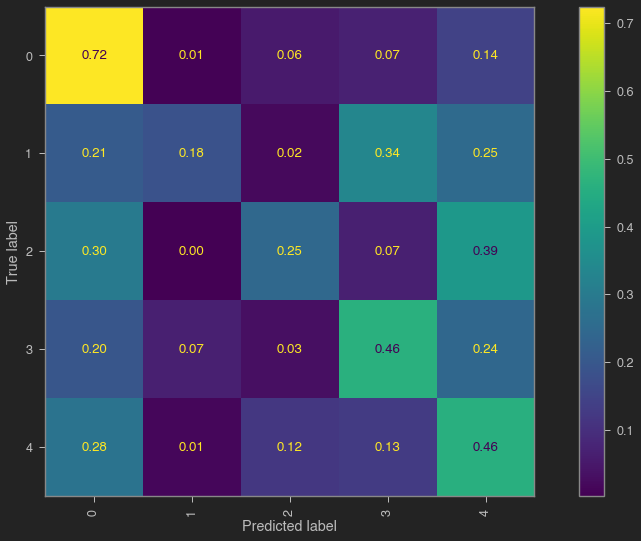

In [17]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix / conf_matrix.astype('float').sum(axis=1, keepdims=True),
)
disp.plot(xticks_rotation='vertical', values_format='.2f');

## Inference

In [18]:
from utils.loops import infer_folder, infer_one_file

In [19]:
image_path = '../data/daisy/10712722853_5632165b04.jpg'
infer_one_file(
    image_path, model, opt.device, transform=val_transformations_without_norm,
    use_descriptors_as_features=opt.use_descriptors_as_features, features_type=opt.features_type
)

2

In [20]:
folder_path = '../data/daisy'
result = infer_folder(
    folder_path, model, opt.device, image_ext='jpg',
    transform=val_transformations_without_norm,
    use_descriptors_as_features=opt.use_descriptors_as_features,
    features_type=opt.features_type
)
result[:5]

[('../data/daisy/14167534527_781ceb1b7a_n.jpg', 0),
 ('../data/daisy/476857510_d2b30175de_n.jpg', 0),
 ('../data/daisy/521762040_f26f2e08dd.jpg', 2),
 ('../data/daisy/7320089276_87b544e341.jpg', 4),
 ('../data/daisy/721595842_bacd80a6ac.jpg', 0)]